## 1. Introduction and Description

<< TODO >>

## 2. Exploratory Data Analysis

<< TODO >> 

In [1]:
# Import Modules
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib.image import imread
import matplotlib.pyplot as plt

# Constants
EPOCHS = 2
BASE_DIR = 'C:/DTSA5311/histopathologic-cancer-detection/'
TRAIN_DIR = f'{BASE_DIR}train/'
TEST_DIR = f'{BASE_DIR}test/'

# Import Train Data
data_df = pd.read_csv(f'{BASE_DIR}/train_labels.csv')
data_df['filename'] = data_df['id'] + '.tif'
data_df.label = data_df.label.astype("string")
data_df.head()

,id,label,filename
0,f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


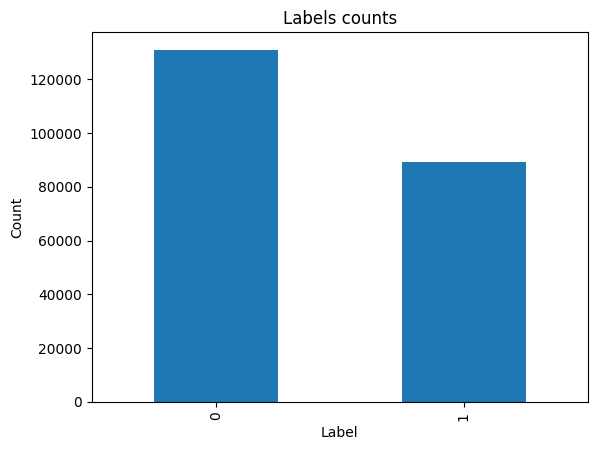

In [2]:
data_df.label.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

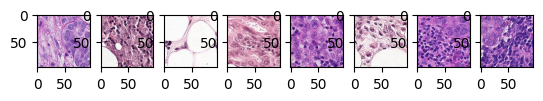

In [3]:
# Plot Positive Label Samples
positive_samples = data_df[data_df.label == '1'].sample(n = 8)
f, axarr = plt.subplots(1, 8)
for i, image_name in enumerate(positive_samples.filename.values):
    axarr[i].imshow(imread(f'{TRAIN_DIR}{image_name}'))

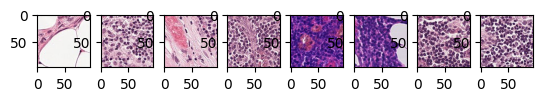

In [4]:
# Plot Negative Label Samples
negative_samples = data_df[data_df.label == '0'].sample(n = 8)
f, ax = plt.subplots(1, 8)
for i, image_name in enumerate(negative_samples.filename.values):
    ax[i].imshow(imread(f'{TRAIN_DIR}{image_name}'))

## 3. Model Architectures and Training

<< TODO >>

### 3.1 Setup and Preparation

<< TODO >>

In [5]:
# Train Test Split
train_df, val_df = train_test_split(data_df, test_size = 0.2, stratify = data_df.label, random_state = 42)
print(train_df.shape)
print(val_df.shape)

(176020, 3)
(44005, 3)


<< TODO >>

In [6]:
# Placeholder
history_val_auc_list = []

# Model Checkpointing
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(model_name,
                                              monitor = 'val_auc',
                                              verbose = 0,
                                              save_best_only = True,
                                              save_weights_only = False,
                                              mode = 'max',
                                              save_freq='epoch')

# Create ImageDataGenerators 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.,
                                                                horizontal_flip=True,
                                                                vertical_flip = True)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

# Applying our generators to our data
train_data = train_datagen.flow_from_dataframe(dataframe = train_df,
                                               directory = TRAIN_DIR, 
                                               x_col = 'filename', 
                                               y_col = 'label',
                                               target_size = (96, 96),
                                               batch_size = 64,
                                               class_mode = 'binary',
                                               shuffle = True)

val_data = valid_datagen.flow_from_dataframe(dataframe = val_df, 
                                             directory = TRAIN_DIR, 
                                             x_col = 'filename', 
                                             y_col = 'label',
                                             target_size = (96, 96), 
                                             batch_size = 64,
                                             class_mode = 'binary',
                                             shuffle = False)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


### 3.2 Custom CNN Model 1

<< TODO >>

In [7]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 1
img = tf.keras.layers.Input(shape = (96, 96, 3))
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(img)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dropout(0.25)(X)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model1 = tf.keras.Model(inputs = img, outputs = preds)

# Compile Model
model1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model1.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_1.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9232672452926636


### 3.3 Custom CNN Model 2

<< TODO >>

In [8]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 2
img = tf.keras.layers.Input(shape = (96, 96, 3))
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(img)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), strides = (1, 1), activation = 'relu')(X)
X = tf.keras.layers.AveragePooling2D(pool_size = (2, 2), strides = (1, 1))(X)
X = tf.keras.layers.Flatten()(X)
X = tf.keras.layers.Dropout(0.25)(X)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model2 = tf.keras.Model(inputs = img, outputs = preds)

# Compile Model
model2.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model2.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_2.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9347794055938721


### 3.4 ResNet50 Model with no pretrained model weights

<< TODO >>

In [9]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 3
resnet_model3 = tf.keras.applications.resnet50.ResNet50(weights = None, 
                                                        include_top = False, 
                                                        input_shape = (96, 96, 3), 
                                                        pooling = 'avg',
                                                        classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model3.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model3 = tf.keras.Model(inputs = resnet_model3.input, outputs = preds)

# Compile Model
model3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model3.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_3.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.92751544713974


### 3.5 ResNet50 Model with 'Imagenet' pretrained model weights (Transfer Learning)

<< TODO >>

In [10]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 4
resnet_model4 = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', 
                                                        include_top = False, 
                                                        input_shape = (96, 96, 3), 
                                                        pooling = 'avg',
                                                        classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model4.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model4 = tf.keras.Model(inputs = resnet_model4.input, outputs = preds)

# Compile Model
model4.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model4.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_4.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9895747900009155


### 3.6 ResNet101 Model with 'Imagenet' pretrained model weights (Transfer Learning)

<< TODO >>

In [11]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 5
resnet_model5 = tf.keras.applications.resnet.ResNet101(weights = 'imagenet', 
                                                     include_top = False, 
                                                     input_shape = (96, 96, 3), 
                                                     pooling = 'avg',
                                                     classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model5.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model5 = tf.keras.Model(inputs = resnet_model5.input, outputs = preds)

# Compile Model
model5.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
               loss = 'binary_crossentropy', 
               metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model5.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_5.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')

# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9902785420417786


### 3.7 ResNet152V2 with 'Imagenet' pretrained model weights (Transfer Learning)

<< TODO >>

In [12]:
# Clear Session
tf.keras.backend.clear_session()

# Create Model 6
resnet_model6 = tf.keras.applications.ResNet152V2(weights = 'imagenet', 
                                                    include_top = False, 
                                                    input_shape = (96, 96, 3), 
                                                    pooling = 'avg',
                                                    classes = None)
X = tf.keras.layers.Dropout(0.25)(resnet_model6.output)
preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
model6 = tf.keras.Model(inputs = resnet_model6.input, outputs = preds)

# Compile Model
model6.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', tf.keras.metrics.AUC()])

# Train Model
history = model6.fit(train_data,
                     epochs = EPOCHS,
                     validation_data = val_data,
                     callbacks = [model_checkpoint('model_6.h5')],
                     verbose = 0)

# Best Result
print(f'Best Validation AUC: {max(history.history["val_auc"])}')
    
# Add Metrics to list
history_val_auc_list.append(history.history['val_auc'])

Best Validation AUC: 0.9884942770004272


### 3.8 Generate Submission Files for each Model

<< TODO >>

In [13]:
test_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')
test_df['filename'] = test_df['id'] + '.tif'
test_df.head()

,id,label,filename
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif
1,95596b92e5066c5c52466c90b69ff089b39f2737,0,95596b92e5066c5c52466c90b69ff089b39f2737.tif
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0,248e6738860e2ebcf6258cdc1f32f299e0c76914.tif
3,2c35657e312966e9294eac6841726ff3a748febf,0,2c35657e312966e9294eac6841726ff3a748febf.tif
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0,145782eb7caa1c516acbe2eda34d9a3f31c41fd6.tif


In [14]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

test_data = test_datagen.flow_from_dataframe(dataframe = test_df, 
                                             directory = TEST_DIR, 
                                             x_col = 'filename', 
                                             class_mode = None,
                                             target_size = (96, 96), 
                                             batch_size = 128,
                                             shuffle = False)

for model_name in ['model_1', 'model_2', 'model_3', 'model_4', 'model_5', 'model_6']:
    print(f'===== Predicting for: {model_name}')
    # Load model
    model = tf.keras.models.load_model(f'{model_name}.h5')

    # Predict on Test Set
    preds = model.predict(test_data, verbose = 0)
    
    # Create and Save Model Submission
    test_df.label = preds
    test_df.to_csv(f'{model_name}_submission.csv', index = False, columns = ['id', 'label'])

Found 57458 validated image filenames.
===== Predicting for: model_1
===== Predicting for: model_2
===== Predicting for: model_3
===== Predicting for: model_4
===== Predicting for: model_5
===== Predicting for: model_6


## 4. Hyperparameter tuning

<< TODO >>

### 4.1 Dropout

<< TODO >>

In [15]:
# Placeholder Dropout
history_val_auc_dropout_list = []

# Loop through Dropout
for dropout in [0.0, 0.25, 0.50]:
    # Clear Session
    tf.keras.backend.clear_session()
        
    # Create Model
    resnet_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', 
                                                           include_top = False, 
                                                           input_shape = (96, 96, 3), 
                                                           pooling = 'avg',
                                                           classes = None)
    X = tf.keras.layers.Dropout(dropout)(resnet_model.output)
    preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
    model = tf.keras.Model(inputs = resnet_model.input, outputs = preds)

    # Compile Model
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', tf.keras.metrics.AUC()])

    # Train Model
    history = model.fit(train_data,
                        epochs = EPOCHS,
                        validation_data = val_data,
                        verbose = 0)

    # Best Result
    print(f'Best Validation AUC for Dropout: {dropout} is: {max(history.history["val_auc"])}')
    
    # Add Metrics to list
    history_val_auc_dropout_list.append(history.history['val_auc'])

Best Validation AUC for Dropout: 0.0 is: 0.9876686334609985
Best Validation AUC for Dropout: 0.25 is: 0.9880372881889343
Best Validation AUC for Dropout: 0.5 is: 0.9883565902709961


### 4.2 Learning Rate

<< TODO >>

In [16]:
# Placeholder Dropout
history_val_auc_lr_list = []

# Loop through Learning Rate
for lr in [0.0001, 0.001, 0.01]:
    # Clear Session
    tf.keras.backend.clear_session()
        
    # Create Model
    resnet_model = tf.keras.applications.resnet50.ResNet50(weights = 'imagenet', 
                                                           include_top = False, 
                                                           input_shape = (96, 96, 3), 
                                                           pooling = 'avg',
                                                           classes = None)
    X = tf.keras.layers.Dropout(0.25)(resnet_model.output)
    preds = tf.keras.layers.Dense(1, activation = 'sigmoid')(X)
    model = tf.keras.Model(inputs = resnet_model.input, outputs = preds)

    # Compile Model
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy', tf.keras.metrics.AUC()])

    # Train Model
    history = model.fit(train_data,
                        epochs = EPOCHS,
                        validation_data = val_data,
                        verbose = 0)

    # Best Result
    print(f'Best Validation AUC for Learning Rate: {lr} is: {max(history.history["val_auc"])}')
    
    # Add Metrics to list
    history_val_auc_lr_list.append(history.history['val_auc'])

Best Validation AUC for Learning Rate: 0.0001 is: 0.9865318536758423
Best Validation AUC for Learning Rate: 0.001 is: 0.9641386866569519
Best Validation AUC for Learning Rate: 0.01 is: 0.8980697989463806


## 5. Results and Analysis 

<< TODO >>

### 5.1 Results for 6 Model Architectures

<< TODO >>

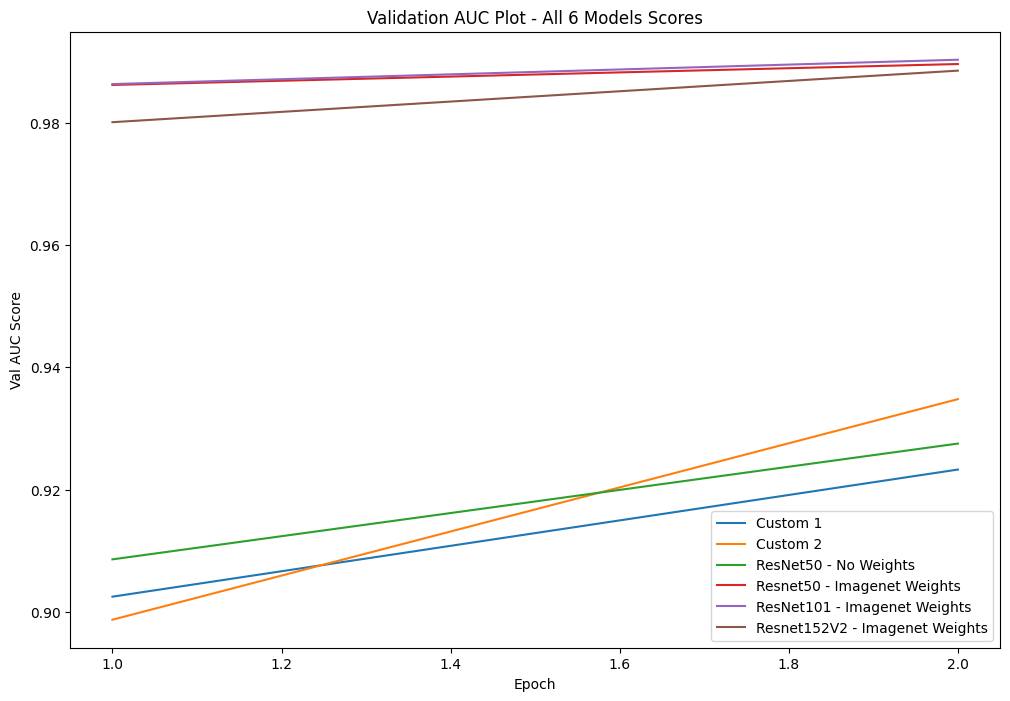

In [20]:
# Plot results for 6 models
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.ylabel("Val AUC Score")
plt.title("Validation AUC Plot - All 6 Models Scores")
epochs_list = list(range(1, len(history_val_auc_list[0])+1))
labels_list = ['Custom 1', 
               'Custom 2', 
               'ResNet50 - No Weights', 
               'Resnet50 - Imagenet Weights', 
               'ResNet101 - Imagenet Weights', 
               'Resnet152V2 - Imagenet Weights']
for i in range(len(history_val_auc_list)):
    plt.plot(epochs_list, history_val_auc_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'lower right')
plt.show()

### 5.2 Hyperparameter tuning - Dropout Results

<< TODO >>

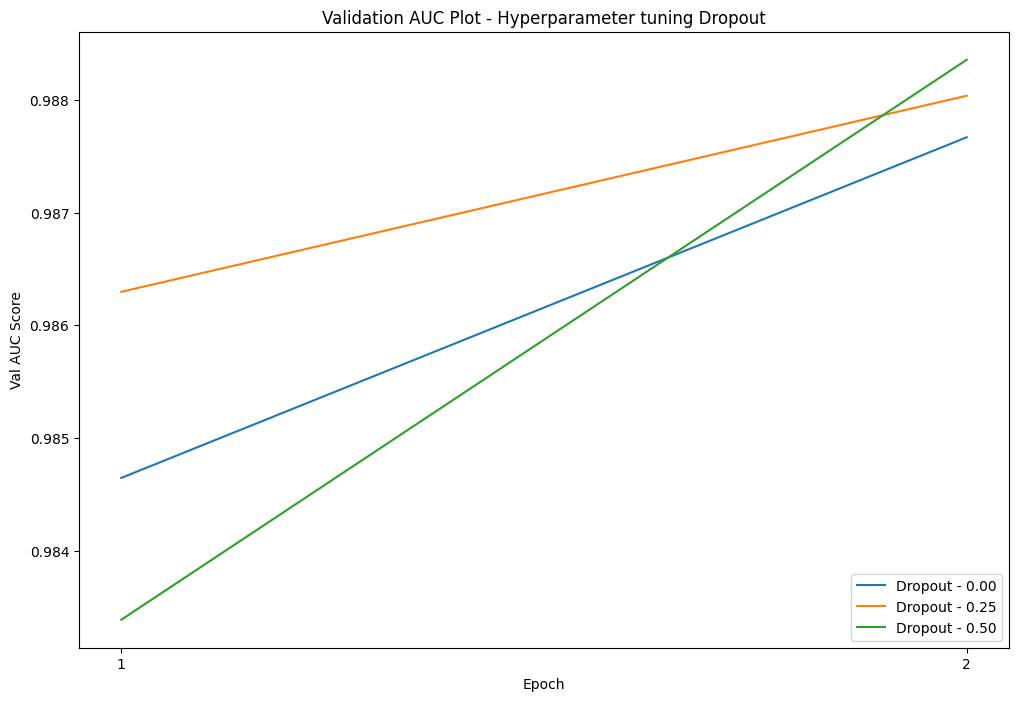

In [21]:
# Plot results for Dropout Hyperparameter tuning
epochs_list = list(range(1, len(history_val_auc_dropout_list[0])+1))
labels_list = ['Dropout - 0.00', 
               'Dropout - 0.25', 
               'Dropout - 0.50']
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.xticks(epochs_list)
plt.ylabel("Val AUC Score")
plt.title("Validation AUC Plot - Hyperparameter tuning Dropout")

for i in range(len(history_val_auc_dropout_list)):
    plt.plot(epochs_list, history_val_auc_dropout_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'lower right')
plt.show()

### 5.3 Hyperparameter tuning - Learning Rate Results

<< TODO >>

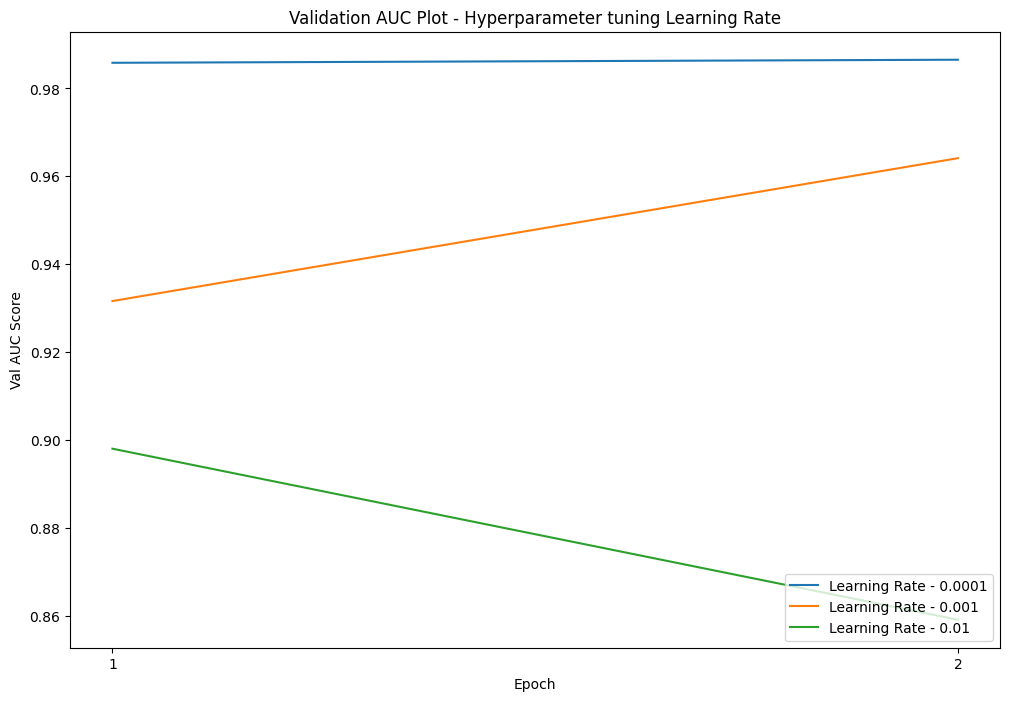

In [22]:
# Plot results for Learning Rate Hyperparameter tuning
epochs_list = list(range(1, len(history_val_auc_lr_list[0])+1))
labels_list = ['Learning Rate - 0.0001', 
               'Learning Rate - 0.001', 
               'Learning Rate - 0.01']
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.xticks(epochs_list)
plt.ylabel("Val AUC Score")
plt.title("Validation AUC Plot - Hyperparameter tuning Learning Rate")

for i in range(len(history_val_auc_lr_list)):
    plt.plot(epochs_list, history_val_auc_lr_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'lower right')
plt.show()

## 6. Conclusion

<< TODO >>